### Upload a data

`X_train` - train image dataset
`Y_train` - train label dataset
`X_test` - test image dataset
`Y_test` - test label dataset

In [ ]:
import random
import matplotlib.pyplot as plt
import pennylane as qml

In [1]:
import numpy as np
from sklearn.decomposition import PCA

In [2]:
from Modules.ImageLoader import ImageLoader
loader = ImageLoader('./Data_Sources/al5083/train', './Data_Sources/al5083/train/train.json', (64, 64))
all_data = loader.load_images(image_limit=100,vertical_start_split=0.3, vertical_end_split=1.0,
                              horizontal_start_split=0.25, horizontal_end_split=0.75)

In [3]:
import Modules.Utils
# Shuffles the dataset and separates it into flattened features and labels.
X_set,Y_set = Modules.Utils.prepare_data(all_data)

In [6]:
X_set[0].shape

(4096,)

In [5]:
n_components=256#512
pca = PCA(n_components=n_components)

In [7]:
pca.fit(X_set)

PCA(n_components=256)

In [8]:
X_set = pca.transform(X_set)

In [9]:
X_set[0].shape

(256,)

Split the data into training sets: 80% of the total data for training

In [35]:
# Split the data into : 80% of the total data for training,20% of the total data for testing
total_data = len(X_set)
X_train, Y_train = X_set[:int(total_data*0.8)], Y_set[:int(total_data*0.8)]
X_val, Y_val = X_set[int(total_data*0.8):], Y_set[int(total_data*0.8):]

This means converting the 2D array of image pixels (16x16 pixels) into a 1D array.

Training set:

In [11]:
values, counts = np.unique(Y_train, return_counts=True)
print(values)
print(counts)

[0 1 2 3 4 5]
[77 79 86 80 83 75]


Testing set:

In [12]:
values, counts = np.unique(Y_val, return_counts=True)
print(values)
print(counts)

[0 1 2 3 4 5]
[23 21 14 20 17 25]


### Model

PEPS architecture - circuit

In [13]:
import pennylane as qml
from pennylane import numpy as np
def block(weights, wires):
    qml.RZ(weights[0], wires=wires[0])
    qml.RY(weights[1], wires=wires[0])
    qml.RZ(weights[2], wires=wires[0])

    qml.RZ(weights[3], wires=wires[1])
    qml.RY(weights[4], wires=wires[1])
    qml.RZ(weights[5], wires=wires[1])

    qml.CNOT(wires=[wires[1], wires[0]])

    qml.RZ(weights[6], wires=wires[0])
    qml.RY(weights[7], wires=wires[1])

    qml.CNOT(wires=[wires[0], wires[1]])

    qml.RY(weights[8], wires=wires[1])

    qml.CNOT(wires=[wires[1], wires[0]])
    
    qml.RZ(weights[9], wires=wires[0])
    qml.RY(weights[10], wires=wires[0])
    qml.RZ(weights[11], wires=wires[0])

    qml.RZ(weights[12], wires=wires[1])
    qml.RY(weights[13], wires=wires[1])
    qml.RZ(weights[14], wires=wires[1])

(<Figure size 9600x900 with 1 Axes>, <Axes: >)

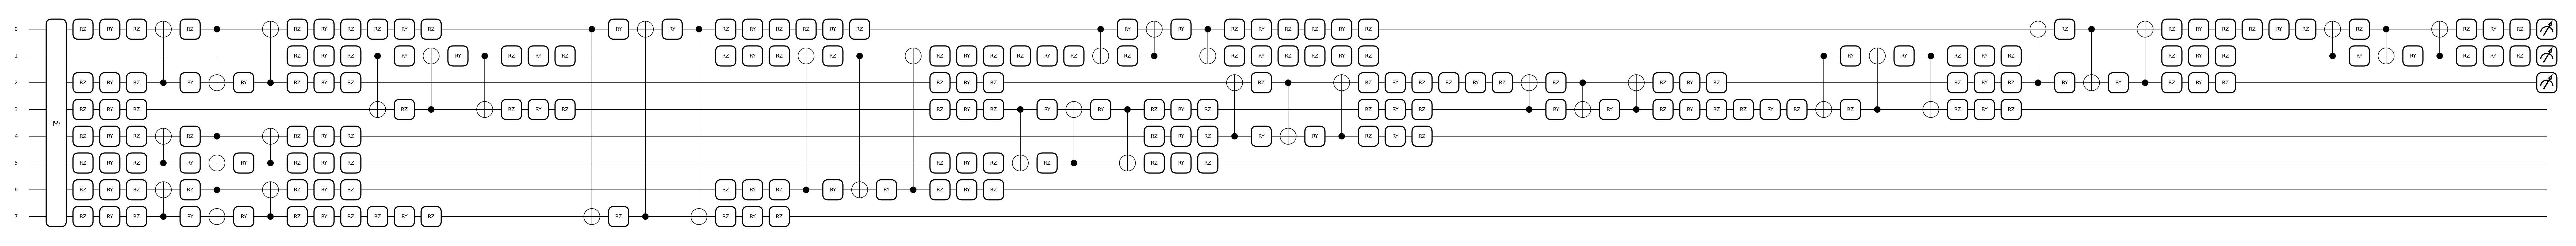

In [14]:
n_wires = 8
n_block_wires = 2
n_params_block = 15
n_blocks = qml.MERA.get_n_blocks(range(n_wires),n_block_wires)
template_weights = [[0.1,-0.3]]*n_blocks


dev= qml.device('default.qubit',wires=range(n_wires))
@qml.qnode(dev)
def circuit_peps(f, template_weights):
    qml.AmplitudeEmbedding(features=f, wires=range(8), normalize=True)
    qml.MERA(range(n_wires),n_block_wires,block, n_params_block, template_weights)
    return qml.probs(wires = [0, 1, 2])


weights = np.random.random(size=[13, 15])
qml.draw_mpl(circuit_peps, expansion_strategy="device")(X_train[0], weights)

Cost function with Cross-Entropy Loss

In [15]:
import math
def costfunc(params):
    cost = 0
    y_true = [np.array([1, 0, 0, 0, 0, 0, 0, 0]), np.array([0, 1, 0, 0, 0, 0, 0, 0]), np.array([0, 0, 1, 0, 0, 0, 0, 0]), np.array([0, 0, 0, 1, 0, 0, 0, 0]), np.array([0, 0, 0, 0, 1, 0, 0, 0]), np.array([0, 0, 0, 0, 0, 1, 0, 0])]
    len_X_train = len(X_train)
    for i in range(len_X_train):
        prob = circuit_peps(X_train[i], params)#[0][0:6]
        #sum_prob = sum([z for z in prob])
        #prob = prob/(sum_prob)
        #print(prob)
        if Y_train[i] == 0:
            cost -= 1/len_X_train * np.sum(np.sum(y_true[0].astype(float)*np.log(prob.astype(float))))
        elif Y_train[i] == 1:
            cost -= 1/len_X_train * np.sum(np.sum(y_true[1].astype(float)*np.log(prob.astype(float))))
        elif Y_train[i] == 2:
            cost -= 1/len_X_train * np.sum(np.sum(y_true[2].astype(float)*np.log(prob.astype(float))))
        elif Y_train[i] == 3:
            cost -= 1/len_X_train * np.sum(np.sum(y_true[3].astype(float)*np.log(prob.astype(float))))
        elif Y_train[i] == 4:
            cost -= 1/len_X_train * np.sum(np.sum(y_true[4].astype(float)*np.log(prob.astype(float))))
        elif Y_train[i] == 5:
            cost -= 1/len_X_train * np.sum(np.sum(y_true[5].astype(float)*np.log(prob.astype(float))))
    return cost

training the circuit parameters

In [17]:
from pennylane import numpy as np
def evaluate_model(params, X_val, Y_val, circuit):
    """
    Evaluate the model on validation data and return the accuracy.

    :param params: The parameters for the quantum circuit.
    :param X_val: Validation set images.
    :param Y_val: Validation set labels.
    :param circuit_MERA: The quantum circuit function that makes predictions.
    :return: Accuracy percentage of the model on the validation set.
    """
    test_correct = 0
    for img, true_label in zip(X_val, Y_val):
        # Get predictions from the quantum circuit
        predictions = circuit(img, params)
        predicted_label = np.argmax(predictions)

        # Increment correct count if prediction matches the true label
        if predicted_label == true_label:
            test_correct += 1

    # Calculate and return the testing accuracy percentage
    accuracy_value = 100 * test_correct / len(X_val)
    return accuracy_value


In [20]:
all_params = []
x2 = np.random.random(size=[13, 15], requires_grad=True)
params = x2[:]
optimizer = qml.AdamOptimizer(stepsize=0.1)
all_params = []
all_cost = []
all_accuracy = []

for k in range(50):

    if k % 5 == 0:
        cost = costfunc(params)
        accuracy_value = evaluate_model(params,X_val, Y_val,circuit_peps)
        all_accuracy.append(accuracy_value)
        all_cost.append(cost)

        print(f"Step {k}, cost: {cost}")
    params = optimizer.step(costfunc, params)
    if k % 5 == 0:
        all_params.append(params)
print(params)

Step 0, cost: 1.9700957019697887
Step 5, cost: 1.4951859568729433
Step 10, cost: 1.3680546136193275
Step 15, cost: 1.305331074450836
Step 20, cost: 1.2265069341585808
Step 25, cost: 1.1384075807682497
Step 30, cost: 1.0787428849133136
Step 35, cost: 1.0332758625383138
Step 40, cost: 1.0118158048612151
Step 45, cost: 1.0023410833868105
[[ 1.24532847  0.40528651 -0.9604926  -0.22627611  0.69264036  0.35121216
   0.55264129  1.3844674   1.55698977  0.60639594 -0.20637506  1.24480745
   0.18704372  0.94445997  0.36539541]
 [ 0.41021886  0.18634676 -0.54044054  0.39607104  0.4658218   0.6048756
   0.5411918   0.89156698  0.4995905  -0.18519052  0.67663804 -0.0643116
   0.59527362  0.86150756 -0.1831544 ]
 [ 2.00734099  1.07346717  0.74275359  2.35771345  0.96953243 -0.32779113
   0.46790957 -0.25091927  0.37530292  0.65538523  0.34276437  0.08846169
   1.27275819 -0.22180491  0.84596398]
 [ 0.91442807  1.09256693  0.762688    0.03101811  0.37058759 -0.13519785
  -0.30227055  0.17334605 -0.2

### Calculating accuracy
On the test set extracted from the training set. When predicted_label does not match test_label, both values are displayed.

In [36]:
 accuracy_value = evaluate_model(all_params[-1],X_val, Y_val,circuit_peps)

In [37]:
accuracy_value

85.0